# QUORA

This notebook is a copy of the IMDB notebook, which is uses in the fast.ai course v3. Thx Jeremy Howard

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
pwd

'/home/martijn/kaggle'

In [4]:
path = Path('../kaggle/data/')


## Preparing the data

Take a look at the data

In [5]:
path.ls()

[PosixPath('../kaggle/data/embeddings'),
 PosixPath('../kaggle/data/models'),
 PosixPath('../kaggle/data/train.csv.zip'),
 PosixPath('../kaggle/data/sample_submission.csv'),
 PosixPath('../kaggle/data/sample_submission.csv.zip'),
 PosixPath('../kaggle/data/test.csv.zip'),
 PosixPath('../kaggle/data/test.csv'),
 PosixPath('../kaggle/data/tmp'),
 PosixPath('../kaggle/data/tmp_lm'),
 PosixPath('../kaggle/data/tmp_clas_n_wt103'),
 PosixPath('../kaggle/data/train.csv'),
 PosixPath('../kaggle/data/tmp_lm_q'),
 PosixPath('../kaggle/data/embeddings.zip'),
 PosixPath('../kaggle/data/tmp_clas')]

In [6]:
df = pd.read_csv(path/'train.csv')
df[df['target']==1].head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


It contains one line per question, with the target ('0' or '1'). 

In [7]:
df_y1 = df[df['target']==1]['question_text']

In [8]:
df_y0 = df[df['target']==0].head(100)

In [9]:
df_y1.head(10)

22     Has the United States become the largest dicta...
30     Which babies are more sweeter to their parents...
110    If blacks support school choice and mandatory ...
114    I am gay boy and I love my cousin (boy). He is...
115                 Which races have the smallest penis?
119                    Why do females find penises ugly?
127    How do I marry an American woman for a Green C...
144    Why do Europeans say they're the superior race...
156    Did Julius Caesar bring a tyrannosaurus rex on...
167    In what manner has Republican backing of 'stat...
Name: question_text, dtype: object

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the questions lefts by people on QUORA isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [10]:
data_lm = (TextList.from_csv(path, 'train.csv', col='question_text')
                .random_split_by_pct(0.1)           
           #We randomly split and keep 10% (10,000 questions) for validation
                .label_for_lm()   
            #We want to do a language model so we label accordingly
                .databunch()
                )
data_lm.save('tmp_lm_q')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [5]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm_q', bs=35)

In [12]:
data_lm

TextLMDataBunch;
Train: LabelList
y: LMLabel (1175510 items)
[0 0 0 0 ... 0 0 0 0]
Path: .
x: TextList (1175510 items)
[list([4, 3, 13, 58, 6636, 7154, 171, 69, 6024, 45, 8, 1155, 10, 5, 8186, 2])
 list([4, 3, 14, 19, 31, 38, 3937, 482, 17, 13, 44, 19, 3677, 46, 9, 3168, 15, 54, 1854, 2])
 list([4, 3, 22, 32, 2017, 388, 84, 2, 32, 2017, 388, 465, 5590, 2])
 list([4, 3, 13, 58, 12865, 8362, 55592, 134, 5, 40241, 27558, 2]) ...
 list([4, 3, 32, 916, 10, 20, 1466, 31, 67, 124, 2608, 10, 20, 289, 30, 55, 71, 50, 16, 79, 23, 369, 751, 2])
 list([4, 3, 7, 7676, 12239, 3022, 2]) list([4, 3, 13, 21, 70, 133, 8, 442, 601, 408, 29, 5982, 56, 3391, 426, 2])
 list([4, 3, 52, 4969, 10, 8, 1506, 83, 8, 8311, 15, 8, 20684, 2])]
Path: ../kaggle/data;
Valid: LabelList
y: LMLabel (130612 items)
[0 0 0 0 ... 0 0 0 0]
Path: .
x: TextList (130612 items)
[list([4, 3, 6, 297, 11, 2966, 152, 8, 156, 192, 21, 516, 31086, 105, 63, 125, 196, 15, 21, 585, 0, 45, 2247, 5170, 139, 2])
 list([4, 3, 24, 267, 7, 10, 8

In [13]:
data_lm.show_batch()

idx,text
0,"xxfld 1 what is a moonshot ? xxfld 1 what are some of the prominent english newspapers or magazines that publish opinionated articles in india ? xxfld 1 i am catering based firm how do i get clients ? xxfld 1 how do i write ' arbitrary ' instance ( haskell ) for propositional logic ( recursive data type ) ? xxfld 1 what are good hotels for short - term business travelers in karnal , haryana , india ? xxfld 1 is is possible to still work for amazon with a 7yr old petty"
1,"? xxfld 1 does giving marks also depends on examiners mood ? xxfld 1 which country should i choose for pursuing masters in electrical engineering with thesis xxunk ? xxfld 1 if i can program xxup cnc machines with g code , how big of a difference is it to coding and programming ? xxfld 1 do psychopaths experience identity crises ? xxfld 1 what am i supposed to do if my husband avoids having sex with me ? xxfld 1 what if brazil was facist during xxup wwii ? xxfld 1 how can one"
2,"pansexual and bisexual the same thing ? xxfld 1 why does america give wealth to liars , cheaters , pedophiles , rapists , murderers , and thieves , put them on a pedestal and worship them as idols ? xxfld 1 how about our inside ? xxfld 1 what is the best career pathway for a computer science student for the future ? xxfld 1 what are the best ways to get from berlin , germany to munich , germany ? xxfld 1 what are the types of fungi found in the taiga ? xxfld"
3,celibate for 20 years ? xxfld 1 why was surge discontinued ? xxfld 1 if the column is a list of several different numbers how can i change them all to be a negative number ? xxfld 1 how has the internet changed life in africa ? xxfld 1 where do you buy a gun in australia ? xxfld 1 why is it illegal to pet a turtle ? xxfld 1 why do women feel the need to reject men who do n't find them attractive ? xxfld 1 can you compare health insurance policies
4,"acceleration 2 m / s for half minute ? xxfld 1 what 's the easiest way to explore top posts across facebook ? xxfld 1 what pronouns should i use writing about an unknown gender child : he , she , it or they ? xxfld 1 what will be the cutoff for xxup jee mains 2017 as board marks will not be added ? cutoff increases or decreases ? xxfld 1 what is the difference between static & dynamic array ? xxfld 1 what are the most annoying finance questions on quora ? xxfld"
5,? xxfld 1 is tinder safe to use ? xxfld 1 what animals can you hunt them eat ? xxfld 1 why is my airtel net so slow while downloading but fast in other cases ? xxfld 1 what is the silent treatment good for ? xxfld 1 did babur inspect his soldiers before every war ? xxfld 1 what is the cheapest possible cost to purify 1 gallon of water ? xxfld 1 how would the first human beings have known that water was one of the main substances that would keep them alive
6,"xxfld 1 how do i make my stepmom sex with me ? xxfld 1 what is first quarter of moon ? xxfld 1 what challenges did xxunk xxunk face when becoming an author ? xxfld 1 if i am 160 cm tall and 81 kg heavy applying for a swiss citizenship , will i be excluded from a swiss military service because of my physique ? xxfld 1 what percentage of the people in the world can solve a 3x3 rubik 's cube currently ? xxfld 1 how did spain become a country ? xxfld"
7,"rate change for the emotions like anger , happiness , stress , depression etc . ? xxfld 1 which anime was the first anime to use the n word ? xxfld 1 is it the purpose of islam to establish sharia law everywhere on earth ? xxfld 1 why would alzheimer 's patients refuse xxunk grapes ? xxfld 1 how do predators find food with their noses ? xxfld 1 how will marketing of tomorrow be different from marketing of today ? will it be more analytical in nature ? xxfld 1 is there a"
8,"? xxfld 1 how good is the xxup xlri xxup gmp program for someone who wants to switch from an it background to a marketing role ? also , what are the placements like ? xxfld 1 what are the examples of meteorology ? xxfld 1 what are the pros 

In [14]:
 data_lm.vocab.itos

['xxunk',
 'xxpad',
 '?',
 '1',
 'xxfld',
 'the',
 'what',
 'is',
 'a',
 'to',
 'in',
 'of',
 'i',
 'how',
 'do',
 'and',
 'are',
 ',',
 'for',
 'you',
 'xxup',
 'can',
 'why',
 'it',
 'my',
 'that',
 '.',
 'if',
 'with',
 'on',
 'or',
 'have',
 'does',
 'be',
 '"',
 "'s",
 'from',
 'your',
 'an',
 'should',
 'which',
 'when',
 'get',
 'best',
 'would',
 'as',
 'people',
 ')',
 '-',
 'some',
 'there',
 '(',
 'who',
 'will',
 'not',
 'like',
 'at',
 "n't",
 'did',
 'about',
 'they',
 'by',
 'was',
 '/',
 'we',
 'any',
 'so',
 'good',
 'me',
 'their',
 'one',
 'india',
 'has',
 'after',
 'most',
 'where',
 'make',
 'this',
 'but',
 'more',
 'all',
 'think',
 'many',
 'between',
 'time',
 'than',
 'much',
 'other',
 'he',
 'someone',
 'life',
 'use',
 'out',
 'way',
 'am',
 'know',
 "'",
 'up',
 'being',
 'work',
 'want',
 'take',
 'were',
 'them',
 'ever',
 'his',
 'find',
 'us',
 'world',
 'could',
 'become',
 'person',
 'without',
 'just',
 'feel',
 'into',
 'better',
 'quora',
 'year'

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [6]:
learn_lm = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

In [16]:

learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


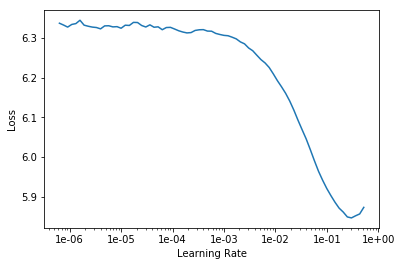

In [17]:
learn_lm.recorder.plot(skip_end=15)

In [18]:
learn_lm.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))

Total time: 28:24
epoch  train_loss  valid_loss  accuracy
1      4.049920    3.894225    0.362843  (28:24)



In [19]:
learn_lm.save('fit_head')

In [7]:
learn_lm.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [8]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(2, slice(1e-3,1e-2), moms=(0.8,0.7))

Total time: 1:04:06
epoch  train_loss  valid_loss  accuracy
1      3.738632    3.647199    0.388309  (31:59)
2      3.531301    3.498232    0.402309  (32:07)



In [9]:
learn_lm.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [10]:
learn_lm.load('fine_tuned');

In [11]:
learn_lm.predict('What are some words', 20, temperature=1.1, min_p=0.001)

Total time: 00:00



'What are some words in first time ? xxfld 1 million of the most of the two " i get you have lived as'

In [12]:
doc(learn_lm.predict)

In [13]:
learn_lm.predict('What is the most amazing', 10, temperature=1.1, min_p=0.001)

Total time: 00:00



'What is the most amazing knowledge for the united states that would you do you'

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

In [14]:
learn_lm.save('fine_tuned_e3')

In [15]:
learn_lm.save_encoder('fine_tuned_enc_wt103')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [16]:
data_clas = (TextList.from_csv(path, 'train.csv', col='question_text', vocab=data_lm.vocab)
                .random_split_by_pct(0.1) 
                .label_from_df(cols='target')
                .databunch()
              )            

In [17]:
data_clas.save('tmp_clas_wt103')

In [63]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas_wt103', bs=35)
data_clas.show_batch(10)

text,label
xxfld 1 what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty },1
"xxfld 1 i am a man who is absolutely uncomfortable with women who can overpower me , control me , dominate me , screw me or kick my ass in any way or pose any sort of threat to me . am i unique in feeling this way ? are",0
"xxfld 1 last night i had clear visuals with my eyes closed of perfect geometric things with vibrant colors and patterns . i saw a linear 3d fly and i could zoom in and out her body , like a wire sculpture . does this have to do with science",0
"xxfld 1 why do you have comments disabled on the white privilege question you answered that has had so many views and upvotes ? i completely disagree with you and every comment i read , but i ’m not allowed to say in your thread . do n’t you think",1
"xxfld 1 baking is my favorite thing to do ; especially brownies . but all of a sudden , my family is trying to get in it , even though i explained to them in detail , how i like having things that only i can do . am i",0
xxfld 1 can a guy still be shy around a girl even if he walks and carries himself confidently ? people i have opened up to tell me the guy who stares at me when he thinks i 'm not looking is shy but he carries himself confidently even when,0
"xxfld 1 i 'm very weak at math , i ca nt even do 10th grade math so xxup cat and xxup gmat are impossible for me to crack . how do i get into a top b - school or management college without xxup cat or xxup gmat ?",0
"xxfld 1 why do women claim it was they who secured freedoms , if they do n't acknowledge that they did n't secure them centuries ago ? and why , if they claim men were oppressing them , why do n’t they acknowledge that men stopped oppressing them ?",1
"xxfld 1 if people think you are monster , but you are full of love of life and these people are life so you are full of love for these people but you have tourette 's syndrome , how could you possibly go about expressing this without triggers ?",0
"xxfld 1 why does david deutsch say all 3 of matter , energy , and evidence are needed for a stream of explanatory knowledge ( chapter 3 of the beginning of infinity ) ? why does n't the existence of one imply the existence of the others ?",0


In [19]:
data_clas.train_ds.c

2

In [20]:
data_clas.vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             '?': 2,
             '1': 3,
             'xxfld': 4,
             'the': 5,
             'what': 6,
             'is': 7,
             'a': 8,
             'to': 9,
             'in': 10,
             'of': 11,
             'i': 12,
             'how': 13,
             'do': 14,
             'and': 15,
             'are': 16,
             ',': 17,
             'for': 18,
             'you': 19,
             'xxup': 20,
             'can': 21,
             'why': 22,
             'it': 23,
             'my': 24,
             'that': 25,
             '.': 26,
             'if': 27,
             'with': 28,
             'on': 29,
             'or': 30,
             'have': 31,
             'does': 32,
             'be': 33,
             '"': 34,
             "'s": 35,
             'from': 36,
             'your': 37,
             'an': 38,
             'should': 39,
             'which': 40,
             'whe

In [21]:
data_clas.valid_ds.x

TextList (130612 items)
[list([4, 3, 22, 39, 1618, 6185, 1397, 1216, 840, 328, 10, 5, 393, 41, 5, 1397, 820, 57, 14, 5, 151, 18, 554, 1216, 2])
 list([4, 3, 13, 21, 1671, 195, 1635, 166, 233, 998, 2]) list([4, 3, 13, 616, 1263, 41544, 10, 420, 20, 15559, 2])
 list([4, 3, 40, 1056, 1472, 16, 8292, 48, 10377, 2]) ... list([4, 3, 13, 14, 12, 470, 670, 15, 1958, 872, 2])
 list([4, 3, 22, 14, 46, 321, 219, 29, 117, 25, 60, 109, 113, 296, 998, 2])
 list([4, 3, 14, 64, 31, 65, 2845, 2263, 1046, 10, 611, 2])
 list([4, 3, 6, 16, 5, 596, 1489, 9, 609, 97, 8, 20, 6658, 3947, 607, 176, 18, 3, 1732, 45, 318, 45, 1001, 7789, 223, 45, 161, 17, 152, 405, 2])]
Path: ../kaggle/data

We can then create a model to classify those reviews and load the encoder we saved before.

In [22]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [23]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5, metrics=[accuracy, fbeta]) #the metrics doesn't work

In [36]:
learn_clas.load_encoder('fine_tuned_enc_wt103')
learn_clas.freeze()

In [25]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


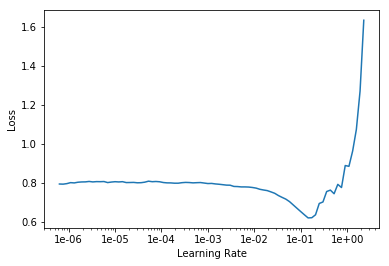

In [26]:
learn_clas.recorder.plot()

In [27]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 22:07
epoch  train_loss  valid_loss  accuracy
1      0.158572    0.169488    0.945564  (22:07)



In [ ]:
learn_clas.save('first_wt103')

In [37]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))


Total time: 1:43:11
epoch  train_loss  valid_loss  accuracy
1      0.124179    0.114981    0.956926  (34:16)
2      0.132324    0.119440    0.956895  (32:10)
3      0.126124    0.113798    0.957661  (36:44)



In [38]:
learn_clas.save('second_wt103_09576')

In [64]:
q1 = ' My voice range is A2-C5. My chest voice goes up to F4. Included sample in my higher chest range. What is my voice type?'
q2 = ' My boy friend and I have very different backgrounds (economically, socially and culturally). Sometimes I feel I deserve better. What should I do?'
q3 = 'When is it appropriate to use parametric survival analysis over non-parametric analysis?'


q4 = 'Has the United States become the largest dictatorship in the world?' #(from trainset value 1)
q5 = "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?" #(from trainset value 1)
q6 = "why do you have comments disabled on the white privilege question you answered that has had so many views and upvotes ? i completely disagree with you and every comment i read , but i ’m not allowed to say in your thread . do n’t you think" 
q7 = "Can Russia learn from Singapore's effort of eliminating corruption given younger Russian voters call for more anti-corruption, and that both are dictator states?"

q_list = [q1,q2,q3,q4,q5]


In [55]:
learn_clas.load('second_wt103_09576')

RNNLearner(data=TextClasDataBunch;
Train: LabelList
y: CategoryList (1175510 items)
[0 0 0 0 ... 0 0 0 0]
Path: .
x: TextList (1175510 items)
[list([4, 3, 13, 58, 6636, 7154, 171, 69, 6024, 45, 8, 1155, 10, 5, 8186, 2])
 list([4, 3, 22, 32, 2017, 388, 84, 2, 32, 2017, 388, 465, 5590, 2])
 list([4, 3, 13, 58, 12865, 8362, 55592, 134, 5, 40241, 27558, 2])
 list([4, 3, 21, 12, 1128, 40242, 0, 1110, 9, 8, 3135, 1537, 61, 113, 1495, 5, 9523, 2]) ...
 list([4, 3, 6, 87, 1203, 545, 14, 19, 135, 45, 8, 241, 201, 3498, 87, 85, 731, 15, 1892, 2])
 list([4, 3, 7, 7676, 12239, 3022, 2]) list([4, 3, 13, 21, 70, 133, 8, 442, 601, 408, 29, 5982, 56, 3391, 426, 2])
 list([4, 3, 52, 4969, 10, 8, 1506, 83, 8, 8311, 15, 8, 20684, 2])]
Path: ../kaggle/data;
Valid: LabelList
y: CategoryList (130612 items)
[0 0 0 0 ... 0 0 0 0]
Path: .
x: TextList (130612 items)
[list([4, 3, 22, 39, 1618, 6185, 1397, 1216, 840, 328, 10, 5, 393, 41, 5, 1397, 820, 57, 14, 5, 151, 18, 554, 1216, 2])
 list([4, 3, 13, 21, 1671, 

In [48]:
learn_clas.load('first_wt103')

RNNLearner(data=TextClasDataBunch;
Train: LabelList
y: CategoryList (1175510 items)
[0 0 0 0 ... 0 0 0 0]
Path: .
x: TextList (1175510 items)
[list([4, 3, 13, 58, 6636, 7154, 171, 69, 6024, 45, 8, 1155, 10, 5, 8186, 2])
 list([4, 3, 22, 32, 2017, 388, 84, 2, 32, 2017, 388, 465, 5590, 2])
 list([4, 3, 13, 58, 12865, 8362, 55592, 134, 5, 40241, 27558, 2])
 list([4, 3, 21, 12, 1128, 40242, 0, 1110, 9, 8, 3135, 1537, 61, 113, 1495, 5, 9523, 2]) ...
 list([4, 3, 6, 87, 1203, 545, 14, 19, 135, 45, 8, 241, 201, 3498, 87, 85, 731, 15, 1892, 2])
 list([4, 3, 7, 7676, 12239, 3022, 2]) list([4, 3, 13, 21, 70, 133, 8, 442, 601, 408, 29, 5982, 56, 3391, 426, 2])
 list([4, 3, 52, 4969, 10, 8, 1506, 83, 8, 8311, 15, 8, 20684, 2])]
Path: ../kaggle/data;
Valid: LabelList
y: CategoryList (130612 items)
[0 0 0 0 ... 0 0 0 0]
Path: .
x: TextList (130612 items)
[list([4, 3, 22, 39, 1618, 6185, 1397, 1216, 840, 328, 10, 5, 393, 41, 5, 1397, 820, 57, 14, 5, 151, 18, 554, 1216, 2])
 list([4, 3, 13, 21, 1671, 

predict target 0 questions from trainset

In [56]:
learn_clas.predict(q1)


(0, tensor(0), tensor([9.9933e-01, 6.7358e-04]))

In [57]:
learn_clas.predict(q2)


(0, tensor(0), tensor([1.0000e+00, 4.2359e-09]))

In [58]:
learn_clas.predict(q3)


(0, tensor(0), tensor([1., 0.]))

predict target 1 questions from trainset

In [59]:
learn_clas.predict(q5)

(0, tensor(0), tensor([1., 0.]))

In [65]:
learn_clas.predict(q6)


(0, tensor(0), tensor([1., 0.]))

In [61]:
learn_clas.predict(q7)


(0, tensor(0), tensor([1., 0.]))

In [62]:
i = 0
for q in q_list:
    i = i +1
    print (i)
    print("predict {}: ".format(i))
    print(learn_clas.predict(q)[0]) #prints dissappear

0


In [ ]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn_clas.save('second')

In [ ]:
learn_clas.load('second');

In [ ]:
learn_clas.predict(q2, 100, temperature=1.1, min_p=0.001)

In [ ]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn_clas.save('third')

In [ ]:
learn_clas.load('third');

In [ ]:
learn_clas.predict(q3, 100, temperature=1.1, min_p=0.001)

In [ ]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn_clas.predict("I really loved that movie, it was awesome!")